# EM casing response

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [20]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [21]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [22]:
run_simulations = True
directory = f"{path_to_data}/fields_permeability_j"

In [4]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 500

In [5]:
# diffusion distance
1260 * np.sqrt(1/sigma_back)

3984.469851812158

In [6]:
return_electrode_r = 500
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0, 0.]

In [7]:
csz = 5
npadz = 16
pf = 1.5

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=13,
    csx2= 25,
    domain_x=return_electrode_r
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)

142560


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [8]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    (1e-4, nt), (3e-4, nt), 
    (1e-3, nt*2), (3e-3, nt*2),
    (6e-3, nt*3), (1e-2, nt),
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max())

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back)):1.0f} m")

1.0933200000000007
diffusion distance 4171 m


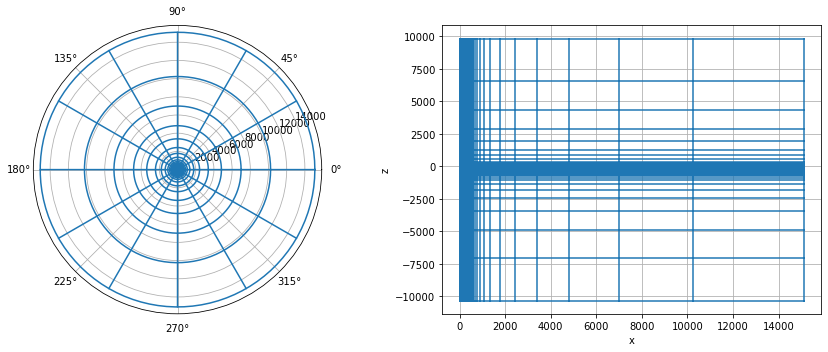

In [9]:
ax = mesh.plot_grid()

In [10]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
inds_casing = inds_casing_x & inds_casing_z

In [11]:
mur_casing

array([  1,  50, 100, 150, 200])

In [12]:
halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

casing_conductivity = halfspace_conductivity.copy()
casing_conductivity[inds_casing] = sigma_casing

casing_permeability = {
}

for mur in mur_casing: 
    casing_mur = np.ones(mesh.n_cells)
    casing_mur[inds_casing] = mur
    casing_permeability[mur] = casing_mur

In [13]:
def plot_casing(ax): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, casing_conductivity, pcolor_opts=pcolor_opts, ax=ax,
    )
    out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
    ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
    ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
    for sign in np.r_[-1, 1]: 
        ax.arrow(
            0, -casing_l+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )

        ax.arrow(
            0, -casing_l-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )
    ax.text(0, -casing_l+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
    ax.text(0, -casing_l-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [14]:
def plot_geometry(ax):
    survey_lim = (return_electrode_r + 70) * np.r_[-1, 1]
    norm = LogNorm(vmin=sigma_air, vmax=sigma_casing)
    cmap = colormap.get_cmap("Spectral_r")
    ax.set_facecolor(cmap(norm(sigma_back)))

    ax.plot(np.r_[0, return_electrode_r], np.r_[0, 0], color="k", marker="v")
    ax.plot(np.r_[0, 0], np.r_[0, survey_lim.max()], color="k", ls=":")
    ax.plot(0, 0, "o", color=cmap(norm(sigma_casing)), ms=8)

    ax.text(return_electrode_r/2, 10, "transmitter", ha="center")
    ax.text(0, -75, "casing", ha="center")
    ax.text(-5, survey_lim.max()/2, "receivers", ha="right")

    ax.set_xlim(survey_lim)
    ax.set_ylim(survey_lim)
    ax.set_aspect(1)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    return ax


In [15]:
from matplotlib import rcParams
rcParams["font.size"] = 16

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

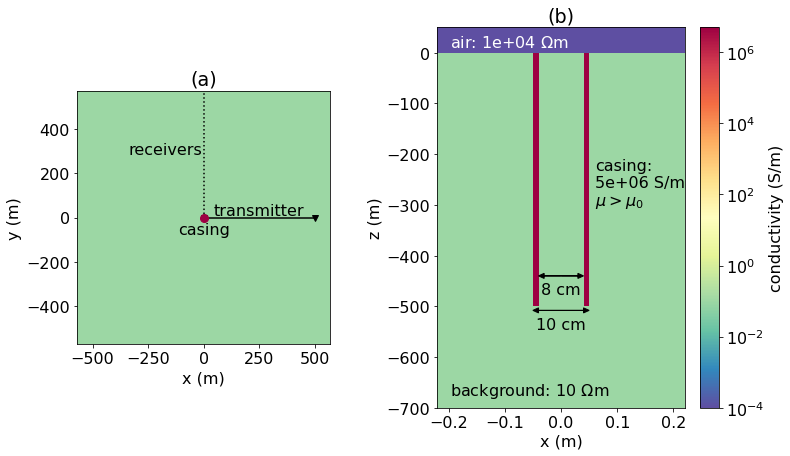

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 1.22], "wspace":0.38})

plot_geometry(ax[0])
plot_casing(ax[1])

ax[0].set_title("(a)")
ax[1].set_title("(b)")


if save_figures:
    fig.savefig(f"{fig_dir_high}/setup.png", dpi=dpi_high)
    fig.savefig(f"{fig_dir_low}/setup.png", dpi=dpi_low)


## set up the simulations

In [30]:
# top casing source 
src_theta = mesh.hy[0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]
src_b = np.r_[return_electrode_r, src_theta, -csz/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(


In [31]:
def generate_simulation(mu=mu_0): 
    src = tdem.sources.LineCurrent([], location=src_locations)
    survey = tdem.Survey([src])
    sim = tdem.simulation.Simulation3DCurrentDensity(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, time_steps=time_steps, 
        mu=mu
    #     verbose=True
    )
    return sim


In [32]:
def load_fields(name, conductivity, permeability):
    solution = np.load(f"{directory}/fields_{name}.npy")
    sim = generate_simulation()
    sim.model = conductivity
    sim.mu = permeability
    f = sim.fieldsPair(sim)
    f[:, sim._fieldType + "Solution", :] = solution
    return f

In [33]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/times", times)

In [34]:
from multiprocessing import Pool

In [35]:
def run_simulation(key):
    t = time.time()
    print(f"starting {key}\n")

    if "casing" in key:
        mur = int(key.split("_")[-1])
        sim = generate_simulation(mu_0 * casing_permeability[mur])
        f = sim.fields(casing_conductivity)
    else:
        sim = generate_simulation()
        f = sim.fields(halfspace_conductivity)
    np.save(f"{directory}/fields_{key}", f[:, f"{sim._fieldType}Solution", :])
    print(f" ... done {key}. {time.time()-t:1.2e} s")

In [36]:
keys = [f"casing_{mur}" for mur in casing_permeability]
keys.append("halfspace")

keys

['casing_1',
 'casing_50',
 'casing_100',
 'casing_150',
 'casing_200',
 'halfspace']

In [37]:
if run_simulations:   
    with Pool(6) as p:
        f = p.map(run_simulation, keys)  
        


starting casing_50
starting casing_1
starting casing_150
starting casing_100
starting casing_200





starting halfspace



/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.war

 ... done casing_1. 4.42e+02 s
 ... done casing_150. 6.57e+02 s
 ... done casing_50. 7.49e+02 s
 ... done casing_200. 7.59e+02 s
 ... done casing_100. 7.59e+02 s
 ... done halfspace. 7.59e+02 s


MaybeEncodingError: Error sending result: '[<SimPEG.electromagnetics.time_domain.fields.Fields3DCurrentDensity object at 0x7fc3861ac970>]'. Reason: 'TypeError('self.a,self.handle cannot be converted to a Python object for pickling')'

In [38]:
fields={}
for key in keys:
    if "casing" in key: 
        mur = int(key.split("_")[-1])
        fields[key] = load_fields(key, casing_conductivity, casing_permeability[mur])
    else: 
        fields[key] = load_fields(key, halfspace_conductivity, casing_permeability[1])

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [39]:
# keys_permeable_only = [f"permeable_only_{mur}" for mur in casing_permeability[1:]]
# with Pool(4) as p: 
#     f_mu_only = p.map(run_simulation, keys_permeable_only)

In [40]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    # 137,
    152,
    169,
    197,
    # 207,
    # 212,
    # 227,
    249,
    283,
] 
print(times[time_inds] * 1e3)

[0.0000e+00 9.9000e-02 9.9000e-01 4.9200e+00 1.0020e+01 3.0320e+01
 1.0032e+02 2.0232e+02]


In [61]:
rcParams["font.size"] = 13

In [62]:
fields.keys()

dict_keys(['casing_1', 'casing_50', 'casing_100', 'casing_150', 'casing_200', 'halfspace'])

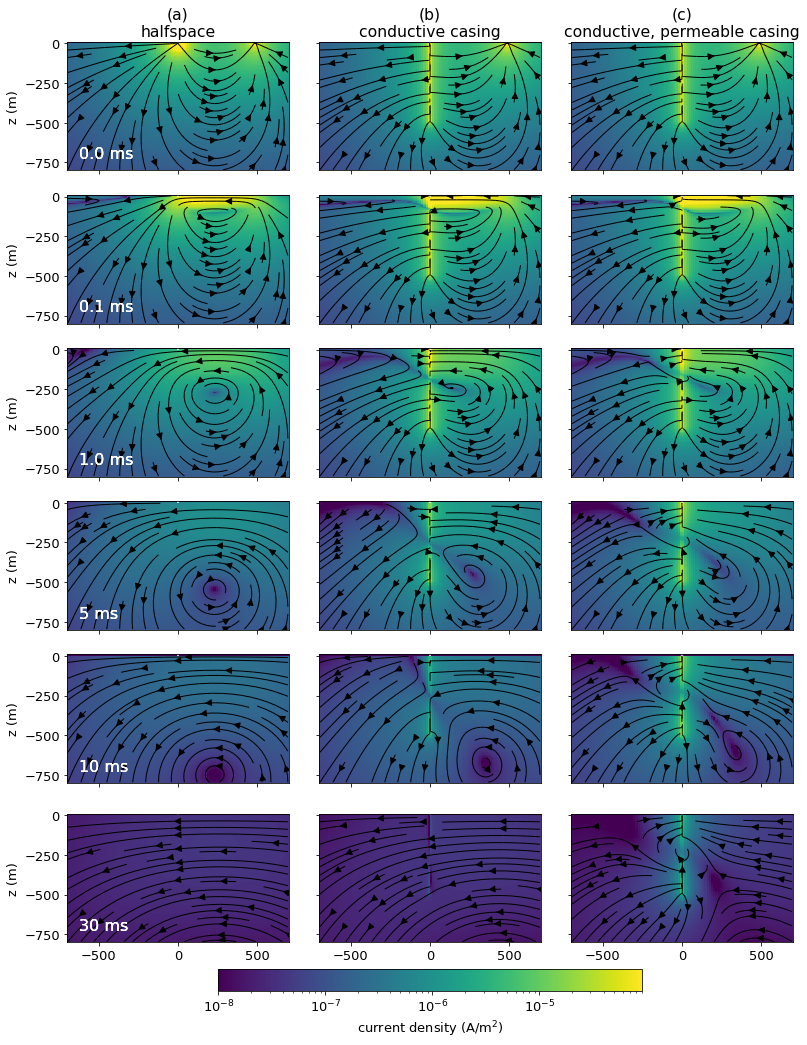

In [64]:
fig, ax = plt.subplots(
    len(time_inds)-2, 3, 
    figsize=(11, (len(time_inds)-2)*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=700 * np.r_[-1, 1]
zlim=np.r_[-800, 10]
clim = np.r_[1e-8, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(["halfspace", "casing_1", "casing_200"]):
    f = fields[key]
    
    for i, ti in enumerate(time_inds[:-2]): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        if times[ti] < 2e-3: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
        if i < len(time_inds)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

ax[0, 0].set_title("(a)\nhalfspace")
ax[0, 1].set_title("(b)\nconductive casing")
ax[0, 2].set_title("(c)\nconductive, permeable casing")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    2, len(time_inds),
    figsize=(len(time_inds)*2.2, 10),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)

xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-5, 1e2]

stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(["casing_1", "casing_200"]):
    f = fields[key]
    
    for j, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        
        if times[ti] < 2e-3: 
            ax[0, j].text(0.05, -550, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
        else: 
            ax[0, j].text(0.05, -550, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
        
        if i == 0:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")

ax[0, 3].set_title("(a) conductive casing", fontsize=18, pad=8)
ax[1, 3].set_title("(b) conductive, permeable casing", fontsize=18, pad=8)

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-casing-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-casing-currents", dpi=dpi_low, bbox_inches="tight")

In [248]:
fields["casing_1"][:, "j", :].shape

(742368, 421)

In [249]:
# look at currents inside the casing

In [53]:
# def get_casing_currents(j):

#     casing_faces_x = (
#         (mesh.gridFx[:, 0] >= casing_a) &
#         (mesh.gridFx[:, 0] <= casing_b) &
#         (mesh.gridFx[:, 2] <= 0) &
#         (mesh.gridFx[:, 2] >= -casing_l)
#     )
#     casing_faces_y = np.zeros(mesh.n_faces_y, dtype=bool)
#     casing_faces_z = (
#         (mesh.gridFz[:, 0] >= casing_a) &
#         (mesh.gridFz[:, 0] <= casing_b) &
#         (mesh.gridFz[:, 2] <= 0) &
#         (mesh.gridFz[:, 2] >= -casing_l)
#     )

#     casing_face_inds = discretize.utils.sdiag(
#         np.hstack([casing_faces_x, casing_faces_y, casing_faces_z])
#     )

#     casing_currents = casing_face_inds * (mesh.face_areas[:, None] * j)

#     casing_current_x = casing_currents[:mesh.n_faces_x, :].reshape(
#         mesh.vnFx[0], mesh.vnFx[1], mesh.vnFx[2], len(sim.times), order='F'
#     )
#     casing_current_z = casing_currents[mesh.nFx + mesh.nFy:, :].reshape(
#         mesh.vnFz[0], mesh.vnFz[1], mesh.vnFz[2], len(sim.times), order='F'
#     )

#     x = {}
#     x["leakage"] = casing_current_x
#     x["total"] = casing_current_x.sum(0).sum(0)
#     x["magnitude"] = np.abs(casing_current_x).sum(0).sum(0)
#     x["positive"] = ((casing_current_x > 0) * casing_current_x).sum(0).sum(0)
#     x["negative"] = ((casing_current_x < 0) * casing_current_x).sum(0).sum(0)
    

#     z = {}
#     z["total"] = casing_current_z.sum(0).sum(0)
#     z["magnitude"] = np.abs(casing_current_z).sum(0).sum(0)
#     z["positive"] = ((casing_current_z > 0) * casing_current_z).sum(0).sum(0)
#     z["negative"] = ((casing_current_z < 0) * casing_current_z).sum(0).sum(0)
    

#     return {"x":x, "z":z}



In [54]:
# integrated_currents = {}
# for key, val in fields.items():
#     integrated_currents[key] = get_casing_currents(val[:, "j", :])

In [55]:
# fig, ax = plt.subplots(3, 1, figsize=(8, 12))
# mur = 1
# for j, k in enumerate([key for key in list(integrated_currents[f"casing_{mur}"]["z"].keys()) if key != "magnitude"]):
#     ax[j].plot(
#         mesh.vectorNz, integrated_currents[f"casing_{mur}"]["z"][k][:, 0::20], color=f"k", alpha=0.4, label=f"{mur} $\mu_0$"
#     );
#     ax[j].set_xlim(0, -50)

#     ax[j].grid()
#     ax[j].set_title(k)

In [56]:
# fig, ax = plt.subplots(3, 1, figsize=(8, 12))
# mur = 1
# for j, k in enumerate([key for key in list(integrated_currents[f"casing_{mur}"]["x"].keys()) if key != "magnitude"]):
#     ax[j].plot(
#         mesh.vectorCCz, integrated_currents[f"casing_{mur}"]["x"][k][:, 0::20], color=f"k", alpha=0.4, label=f"{mur} $\mu_0$"
#     );
#     ax[j].set_xlim(0, -50)

#     ax[j].grid()
#     ax[j].set_title(k)

In [57]:
# time_inds_currents = time_inds[-1]

In [58]:
# fig, ax = plt.subplots(4, 1, figsize=(8, 12))

# for j, k in enumerate(integrated_currents[f"casing_1"]["z"].keys()):
#     for i, mur in enumerate(mur_casing):
#         ax[j].plot(
#             mesh.vectorNz, integrated_currents[f"casing_{mur}"]["z"][k][:, time_inds_currents], color=f"C{i}", alpha=0.7, label=f"{mur} $\mu_0$"
#         );
#         ax[j].set_xlim(0, -casing_l)

#     ax[j].grid()
#     ax[j].set_title(k)

In [59]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# tind = time_inds[-2]
# for i, mur in enumerate(mur_casing):
#     ax.plot(
#         mesh.vectorCCz, integrated_currents[f"casing_{mur}"]["x"]["total"][:, time_inds_currents], color=f"C{i}", alpha=0.7, label=f"{mur} $\mu_0$"
#     );
#     ax.set_xlim(0, -casing_l)

# ax.grid()

In [60]:
# integrated_currents[f"casing_{mur}"]["z"]["positive"]

In [61]:
# fig, ax = plt.subplots(1, 1)

# ax.plot(
#     mesh.vectorNz, integrated_currents[f"casing_{mur}"]["z"]["positive"][:, time_inds_currents], color=f"C{i}", alpha=0.7, label=f"{mur} $\mu_0$"
# );
# ax.set_xlim(0, -casing_l)


In [62]:
# times[time_inds]

In [67]:
plot_spatial = {}

for model_type in ["casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    tmp = {}
    for ti in time_inds:
        primary = discretize.utils.mkvc(fields[f"casing_1"][:,'e', ti])
        total = discretize.utils.mkvc(fields[f"{model_type}"][:,'e', ti])
        tmp[ti] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/np.abs(primary) * 100
        }
    plot_spatial[model_type] = tmp

In [68]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", color=None, label=None):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end]
            if np.all(yvals <= 0):
                getattr(ax, plot_type)(xvals, np.abs(yvals), "--", color=color)
            else: 
                getattr(ax, plot_type)(xvals, yvals, "-", color=color, label=label)
                label=None
        return ax

In [69]:
theta_loc=3

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorCCy has been deprecated, please use CylindricalMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


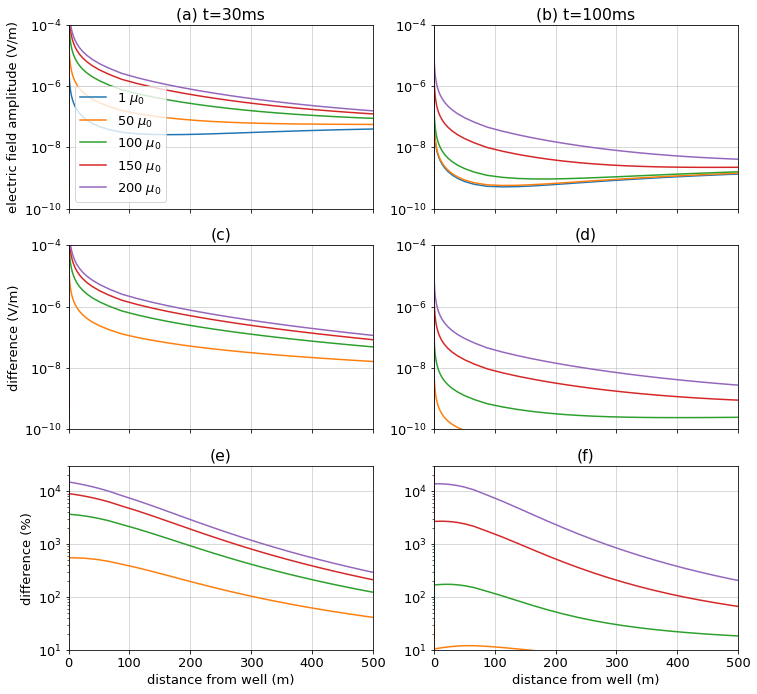

In [70]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11.5), sharex=True)
time_inds_plot = [5, 6]
# time_inds_plot = [2, 3]
zloc = -csz/2
face_inds_plotting = np.hstack([
    ((mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & (mesh.faces_x[:, 2] == zloc)),
    np.zeros(mesh.n_faces_y, dtype=bool), np.zeros(mesh.n_faces_z, dtype=bool)
])

xlim = np.r_[0, 500]

for j, time_ind in enumerate(time_inds_plot): 
    for i, key in enumerate(list(plot_spatial.keys())):
        val = plot_spatial[key][time_inds[time_ind]]
        legend = f"{key.split('_')[-1]} $\mu_0$"
        ax[0, j].semilogy(mesh.cell_centers_x, np.abs(val["total"][face_inds_plotting]), label=legend, color=f"C{i}")
        ax[1, j].semilogy(mesh.cell_centers_x, np.abs(val["difference"][face_inds_plotting]), color=f"C{i}")
        ax[2, j].semilogy(mesh.cell_centers_x, np.abs(val["percent"][face_inds_plotting]), color=f"C{i}")
    
    # plot_pos_neg_log(
    #     mesh.cell_centers_x, val["total"][face_inds_plotting], ax[0], 
    #     "semilogy", label=legend, color=f"C{i}"
    # )
    # plot_pos_neg_log(
    #     mesh.cell_centers_x, val["difference"][face_inds_plotting], ax[1], 
    #     "semilogy", label=legend, color=f"C{i}"
    # )
    # plot_pos_neg_log(
    #     mesh.cell_centers_x, val["percent"][face_inds_plotting], ax[2], 
    #     "semilogy", label=legend, color=f"C{i}"
    # )

ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylabel("electric field amplitude (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")

ylim = np.r_[1e-10, 1e-4]
ylim_percent = np.r_[1e1, 3e4]

for i, a in enumerate(ax.flatten()):
    a.grid("both", alpha=0.6)
    
    
    if i in [0, 1]:
        a.set_title(f"({ascii_lowercase[i]}) t={times[time_inds[time_inds_plot[i]]]*1e3:1.0f}ms")
    else: 
        a.set_title(f"({ascii_lowercase[i]})")
    if i not in [4, 5]:
        a.set_ylim(ylim)
    else: 
        a.set_ylim(ylim_percent)
        a.set_xlabel("distance from well (m)")

ax[0, 0].legend()

if save_figures:
    fig.savefig(f"{fig_dir_high}/motivation-e-fields-space.png", dpi=dpi_high)
    fig.savefig(f"{fig_dir_low}/motivation-e-fields-space.png", dpi=dpi_low)

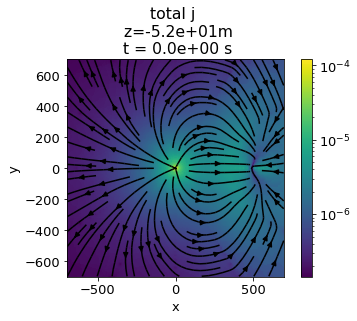

In [75]:
fig, ax = plt.subplots(1, 1)
key = "casing_1"
f = fields[key]
xlim=700*np.r_[-1, 1]

zind = 105
out = casing_sim.view.plot_depth_slice(
    f,
    view="j",
    time_ind=0,
    xlim=xlim,
    ylim=xlim,
    z_ind=zind, 
    theta_shift=0.5*mesh.hy[0],
    ax=ax, 
    # clim=clim,
    # show_cb=False,
    k=20
    # stream_opts=stream_opts
)

ax.set_aspect(1)

In [47]:
xlocs = np.r_[58, 64, 74]
mesh.vectorNx[xlocs]

array([100., 250., 500.])

In [48]:
zloc = -csz/2
theta_loc = 3

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (mesh.faces_x[:, 2] == zloc)
    )[0]
    print(mesh.faces_x[face_inds[i], :])

[100.           1.83259571  -2.5       ]
[250.           1.83259571  -2.5       ]
[500.           1.83259571  -2.5       ]


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorCCy has been deprecated, please use CylindricalMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [49]:
plot_timeseries = {}

for model_type in ["halfspace", "casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    tmp = {}
    for fi in face_inds:
        primary = (discretize.utils.mkvc(fields[f"casing_1"][:,'e', :][fi, :]))
        total = (discretize.utils.mkvc(fields[f"{model_type}"][:,'e', :][fi, :]))
        tmp[fi] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/np.abs(primary) * 100
        }
    plot_timeseries[model_type] = tmp

100.0


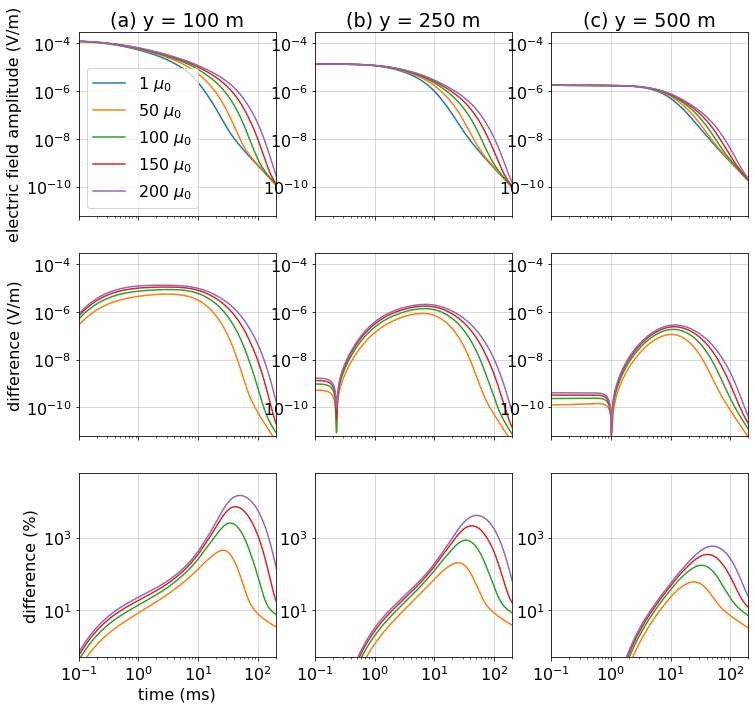

In [54]:
fig, ax = plt.subplots(3, 3, figsize=(12, 11.5), sharex=True)
face_ind = 0
print(mesh.vectorNx[xlocs][face_ind])

xlim = np.r_[1e-1, 2e2]
ylim = np.r_[6e-12, 3e-4]
percent_lim = [5e-1, 6e4]

for j, fi in enumerate([0, 1, 2]):
    for i, key in enumerate(list(plot_timeseries.keys())[1:]):
        val = plot_timeseries[key][face_inds[fi]]
        legend = f"{key.split('_')[-1]} $\mu_0$"
        ax[0, j].loglog(times*1e3, np.abs(val["total"]), label=legend, color=f"C{i}")
        ax[1, j].loglog(times*1e3, np.abs(val["difference"]), color=f"C{i}")
        ax[2, j].loglog(times*1e3, np.abs(val["percent"]), color=f"C{i}")
        # plot_pos_neg_log(sim.times*1e3, val["total"], ax[0], "loglog", label=legend, color=f"C{i}")
        # plot_pos_neg_log(sim.times*1e3, val["difference"], ax[1], "loglog", color=f"C{i}")
        # plot_pos_neg_log(sim.times*1e3, val["percent"], ax[2],"loglog", color=f"C{i}")
        
        ax[0, j].set_ylim(ylim)
        ax[1, j].set_ylim(ylim)
        ax[2, j].set_ylim(percent_lim)
        
        ax[0, j].set_title(f"({ascii_lowercase[j]}) y = {mesh.faces_x[face_inds[fi], 0]:1.0f} m")

ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylabel("electric field amplitude (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")





for a in ax.flatten(): 
    a.grid("both", alpha=0.6)
    
ax[2, 0].set_xlabel("time (ms)")

ax[0, 0].legend(loc=3)


# [a.set_title(f"({letter})") for a, letter in zip(ax, ascii_lowercase)]

# if save_figures:
#     fig.savefig(f"{fig_dir_high}/motivation-e-fields.png", dpi=dpi_high)
#     fig.savefig(f"{fig_dir_low}/motivation-e-fields.png", dpi=dpi_low)

In [ ]:
zloc = 0
theta_loc = 0

edge_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    edge_inds[i] = np.where(
        (mesh.edges_y[:, 0] == mesh.nodes_x[xl]) &
        (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_loc]) & 
        (mesh.edges_y[:, 2] == zloc)
    )[0] + mesh.n_edges_x

In [81]:
plot_timeseries_dbdt = {}

primary_key = "casing_1"

for model_type in ["casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    print(model_type)
    tmp = {}
    for ei in edge_inds:
        total = (discretize.utils.mkvc(fields[f"{model_type}"][:,'dbdt', :][ei, :]))
        if model_type == primary_key: 
            primary = total
        else: 
            primary = plot_timeseries_dbdt[primary_key][ei]["total"]
        
        tmp[ei] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/np.abs(primary) * 100
        }
    plot_timeseries_dbdt[model_type] = tmp

casing_1
casing_50
casing_100
casing_150
casing_200


IndexError: index 3 is out of bounds for axis 0 with size 3

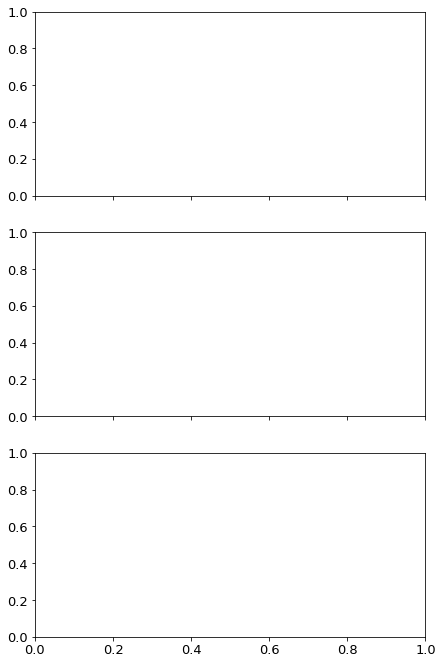

In [92]:
fig, ax = plt.subplots(3, 1, figsize=(7, 11.5), sharex=True)

edge_ind = 3
xlim = np.r_[1e-1, 1e3]

view_key = "total" 

for i, key in enumerate(plot_timeseries_dbdt.keys()):
    val = plot_timeseries_dbdt[key]
    legend = f"{key.split('_')[-1]} $\mu_0$"
    ax[0].loglog(sim.times*1e3, np.abs(val[edge_inds[edge_ind]]["total"]), label=key, color=f"C{i}")
    ax[1].loglog(sim.times*1e3, np.abs(val[edge_inds[edge_ind]]["difference"]), label=key, color=f"C{i}")
    ax[2].loglog(sim.times*1e3, np.abs(val[edge_inds[edge_ind]]["percent"]), label=key, color=f"C{i}")


ax[0].set_xlim(1e-2, 1e3)
ax[0].set_ylim([1e-13, 1e-4])
ax[1].set_ylim([1e-13, 1e-8])
ax[2].set_ylim([1e-3, 2e1])
ax[0].legend()

for a in ax:
    a.grid("both", alpha=0.6)

In [41]:
theta_ind=0
tind_plot=time_inds[2]

def plot_cross_section_field(
    key, field, time_ind=0, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    prime_sec="total", primary_key=None, 
    log_scale=False, eps=1e-15, vmin=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)

    if field in ["b", "h", "dbdt", "dhdt"]: 
        ave = mesh.average_edge_to_cell_vector
    elif field in ["e", "j"]:
        ave = mesh.average_face_to_cell_vector
        
    field_plot = ave * fields[key][:, field, time_ind]
    
    if prime_sec in ["secondary", "percent"]:
        if primary_key is None: 
            primary_key = get_primary_key(key)
        primary = ave * fields[primary_key][:, field, time_ind]
        field_plot = field_plot - primary
        if prime_sec == "percent":
            field_plot = dfield_plot / np.abs(primary + eps) * 100
    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind, :]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror, :]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    # plot x,z vector
    fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
    fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

    sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

    out = mesh2d.plot_image(
        fieldxz, v_type="CCv", view="vec", ax=ax[0],
        range_x=xlim, range_y=zlim,
        sample_grid=sample_grid,
        mirror=True, mirror_data=fieldxz_mirror,
        pcolor_opts={"norm":LogNorm(vmin=vmin)} if log_scale is True else None,
    )
    plt.colorbar(out[0], ax=ax[0])

    
    pcolor_optsy = {"cmap":"Spectral_r"}
    linthresh = vmin if vmin is not None else 1e-3*vmax
    vmin, vmax = 1e-3*np.max(np.abs(field_components["y"]["data"]))*np.r_[-1, 1]
        
    if log_scale is True:
        pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
    else: 
        pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    
    out2 = mesh2d.plot_image(
        field_components["y"]["data"], ax=ax[1],
        mirror=True, mirror_data=field_components["y"]["mirror"],
        range_x=xlim, range_y=zlim, 
        pcolor_opts=pcolor_optsy
    )
    plt.colorbar(out2[0], ax=ax[1])
    return ax

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


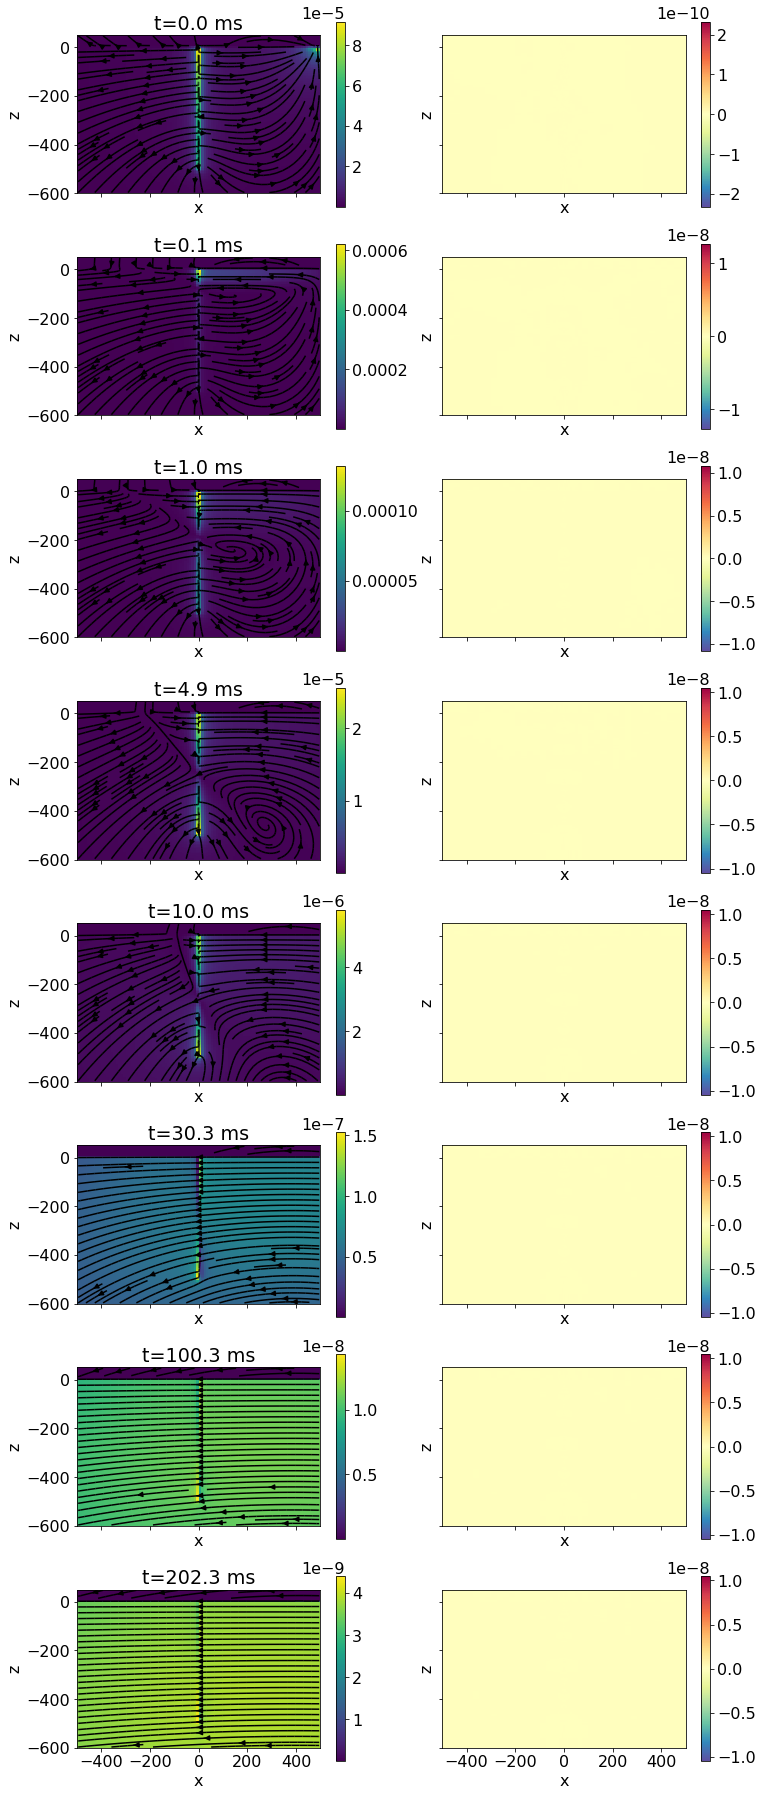

In [42]:
tinds_plot = time_inds 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_1"
primary_key = None #"mu_1_target_1e-01"


for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "j", time_ind=ti, theta_ind=0, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        # prime_sec="secondary", 
        # log_scale=True,
        vmin=1e-13
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

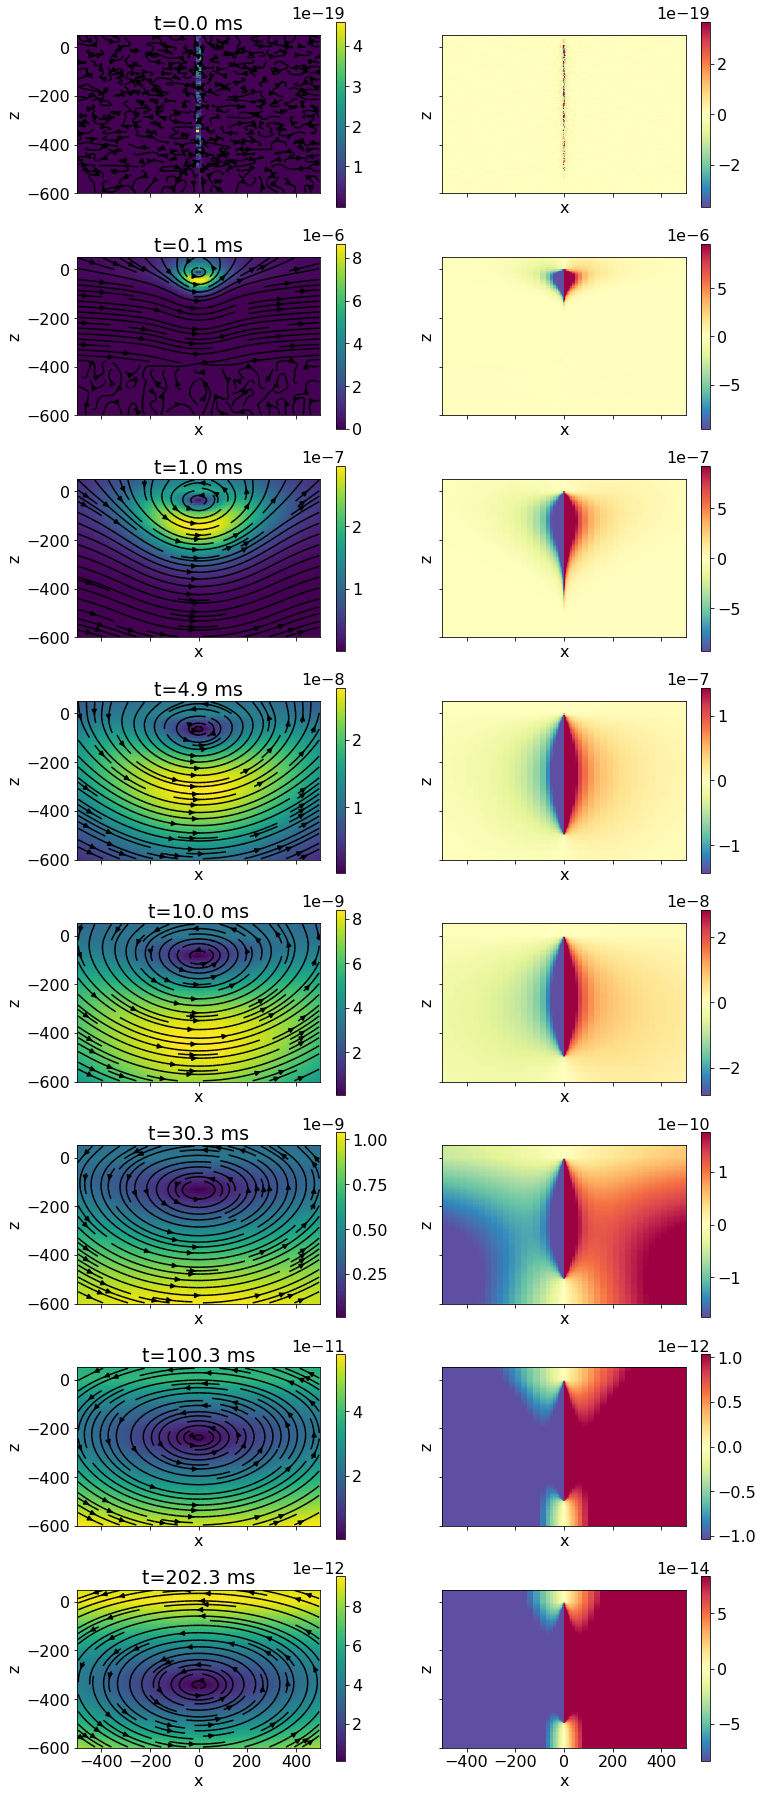

In [44]:
tinds_plot = time_inds 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_1"
primary_key = None #"mu_1_target_1e-01"


for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "dbdt", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        # prime_sec="secondary", 
        # log_scale=True,
        vmin=1e-13
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)